In [134]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astroduet.bbmag import bb_abmag_fluence
from astroduet.image_utils import construct_image, find, ap_phot, run_daophot
from astroduet.config import Telescope
from astroduet.background import background_pixel_rate
from astroduet.utils import duet_abmag_to_fluence
from astropy.table import Table
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astroduet.diff_image import py_zogy
from astroduet.image_utils import estimate_background

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
duet = Telescope()
[bgd_band1, bgd_band2] = background_pixel_rate(duet, low_zodi = True, diag=True)
print(duet.read_noise)

-----
Background Computation Integrating over Pixel Area
Telescope diameter: 26.0 cm
Transmission Efficiency: 0.8166518036622619


Pixel Size: 6.4 arcsec
Pixel Area: 40.96000000000001 arcsec2

Zodi Level: 77
Band1 Rate: 0.030369732491096913 ph / s
Band2 Rate: 0.2478588509265617 ph / s
-----
7


/Users/mheida/software/miniconda2/envs/duet/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [128]:
hdu_ref20 = fits.open('../astroduet/data/image_library/tel_best/gal_spiral/zodi_low/duet1/best_duet1_spiral_20.0_zodi-low_reference.fits')
hdu_ref21 = fits.open('../astroduet/data/image_library/tel_best/gal_spiral/zodi_low/duet1/best_duet1_spiral_21.0_zodi-low_reference.fits')

hdu_im20 = fits.open('../astroduet/data/image_library/tel_best/gal_spiral/zodi_low/duet1/best_duet1_spiral_20.0_zodi-low_src-19.80.fits')
hdu_im21 = fits.open('../astroduet/data/image_library/tel_best/gal_spiral/zodi_low/duet1/best_duet1_spiral_21.0_zodi-low_src-20.80.fits')

In [129]:
image_rate = hdu_im20[1].data / hdu_im20[1].header['EXPTIME'] *u.ph / u.s
ref_image_rate = hdu_ref20[2].data / hdu_ref20[2].header['EXPTIME'] *u.ph / u.s

In [130]:
image_bkg_mean, image_bkg_median, image_bkg_std = sigma_clipped_stats(image_rate, sigma=2, maxiters=None)
ref_bkg_mean, ref_bkg_median, ref_bkg_std = sigma_clipped_stats(ref_image_rate, sigma=1)
image_rate_bkgsub, ref_rate_bkgsub = image_rate - image_bkg_median, ref_image_rate - ref_bkg_median
print(image_bkg_mean, image_bkg_median, image_bkg_std)

0.04304141208418194 ph / s 0.043333333333333335 ph / s 0.02399613107906472 ph / s


In [137]:
image_bkg, image_bkg_rms_median = estimate_background(image_rate, bkg_method='1D', diag=True)
ref_bkg, ref_bkg_rms_median = estimate_background(ref_image_rate)
image_rate_bkgsub2, ref_rate_bkgsub2 = image_rate - image_bkg, ref_image_rate - ref_bkg
print(image_bkg_rms_median)

0.025343850912321955 ph / s


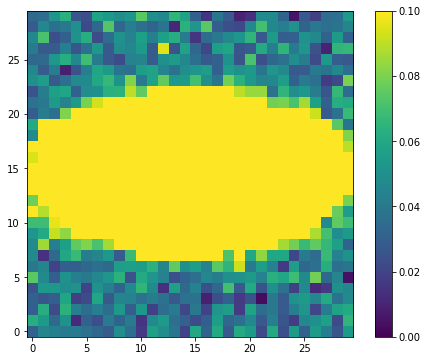

In [138]:
plt.figure(figsize=[8,6])
plt.imshow(ref_image_rate.value, cmap='viridis', aspect=1, origin='lower', vmin=0, vmax=0.1)
plt.colorbar()

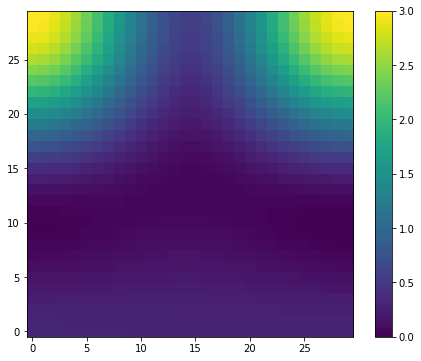

In [139]:
plt.figure(figsize=[8,6])
plt.imshow(ref_bkg.value, cmap='viridis', aspect=1, origin='lower', vmin=0, vmax=3)
plt.colorbar()

In [140]:
# Make a 2D array containing the PSF (oversample then bin up for more accurate PSF)

oversample = 5
pixel_size_init = duet.pixel / oversample

psf_model = duet.psf_model(pixel_size=pixel_size_init, x_size=25, y_size=25)

psf_os = psf_model.array

#psf_os = gaussian_psf(psf_fwhm,(25,25),pixel_size_init)
shape = (5, 5, 5, 5)
psf_array = psf_os.reshape(shape).sum(-1).sum(1)

# Use ZOGY algorithm to create difference image
s_n, s_r = np.sqrt(image_rate), np.sqrt(ref_image_rate) # 2D uncertainty (sigma) - that is, noise on the background
sn, sr = np.mean(s_n), np.mean(s_r) # Average uncertainty (sigma)
dx, dy = 0.1, 0.01 # Astrometric uncertainty (sigma)
diff_image2, d_psf2, s_corr2 = py_zogy(image_rate_bkgsub2.value,
                                    ref_rate_bkgsub2.value,
                                    psf_array,psf_array,
                                    s_n.value,s_r.value,
                                    sn.value,sr.value,dx,dy)

diff_image, d_psf, s_corr = py_zogy(image_rate_bkgsub.value,
                                    ref_rate_bkgsub.value,
                                    psf_array,psf_array,
                                    s_n.value,s_r.value,
                                    sn.value,sr.value,dx,dy)


diff_image *= image_rate_bkgsub.unit
diff_image2 *= image_rate_bkgsub2.unit

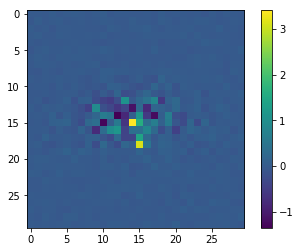

In [141]:
plt.imshow(diff_image.value)
plt.colorbar()
plt.show()

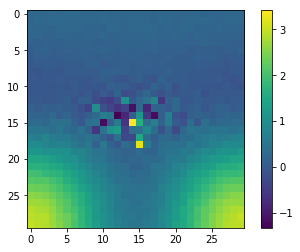

In [142]:
plt.imshow(diff_image2.value)
plt.colorbar()
plt.show()

In [143]:
diff_bkg, sky = estimate_background(diff_image)
print(sky)

0.06228470265477223 ph / s


In [144]:
diff_bkg, sky = estimate_background(diff_image2)
print(sky)

0.29583656042730927 ph / s


In [160]:
diff_bkg_mean, diff_bkg_median, sky = sigma_clipped_stats(diff_image, sigma=100)
print(sky)

0.2362643471925169 ph / s


In [161]:
diff_bkg_mean, diff_bkg_median, sky = sigma_clipped_stats(diff_image2, sigma=100)
print(sky)

0.7860255862675863 ph / s


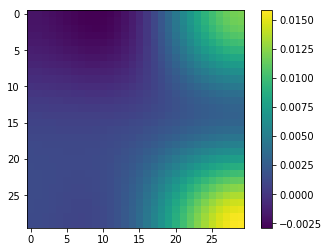

In [62]:
plt.imshow(diff_bkg.value)
plt.colorbar()
plt.show()